# <font style="color:blue">Faster RCNN Fine-tuning Experiment</font>

We are already familiar with the following building block diagram of Faster RCNN. 

---
![](https://www.researchgate.net/profile/Giang_Son_Tran/publication/324549019/figure/fig1/AS:649929152266241@1531966593689/Faster-R-CNN-Architecture-9.png)

---

We want to quickly fine-tune the Faster RCNN model to work for our detection problem.
The last layer (classifier) in the above image takes resized features of all proposed bounding boxes and predicts classes and bounding boxes. For this task, it uses FastRCNNPredictor network. So for fine-tuning with our data, we need to update the number of classes in the predictor. 

To get the Faster RCNN model with the number of classes, we can write the following method.

```
def faster_rcnn_pretrained_model(num_classes):
    # load an instance detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model
```

Let's start training. We will use the trainer pipeline to train and evaluate our model. 


# <font style="color:blue">Experiment (Training)</font>

Let's write the experiment class for Fast RCNN fine-tuning.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import os
import random
import cv2

from operator import itemgetter

import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

from trainer import Trainer, hooks, configuration
from trainer.utils import patch_configs
from trainer.utils import setup_system

from trainer.metrics import APEstimator
from trainer.datasets import ListDataset
from trainer.matplotlib_visualizer import MatplotlibVisualizer
from trainer.utils import collate_fn

from faster_rcnn_detector import faster_rcnn_pretrained_model

import warnings
warnings.filterwarnings('ignore')

## <font style="color:green">1. Experiment Class</font>

In [2]:
class Experiment:
    def __init__(
        self,
        system_config: configuration.SystemConfig = configuration.SystemConfig(),
        dataset_config: configuration.DatasetConfig = configuration.DatasetConfig(),  
        dataloader_config: configuration.DataloaderConfig = configuration.DataloaderConfig(),
        optimizer_config: configuration.OptimizerConfig = configuration.OptimizerConfig(),
    ):
        self.system_config = system_config
        setup_system(system_config)
        
        # fruit detection data has 3-classes. Anything other than these three classes is called background
        self.classes = ['__background__', 'apple', 'banana', 'orange']
        
        # written custom dataset class of our dataset
        train_csv_path = os.path.join(dataset_config.root_dir, 'labels_train.csv')
        self.dataset_train = ListDataset(
            csv_path=train_csv_path,
            train = True,
            transform=None
        )

        self.loader_train = DataLoader(
            dataset=self.dataset_train,
            batch_size=dataloader_config.batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=dataloader_config.num_workers,
            pin_memory=True
        )
        
        test_csv_path = os.path.join(dataset_config.root_dir, 'labels_test.csv')

        self.dataset_test = ListDataset(
            csv_path=test_csv_path,
            train=False,
            transform=None
        )
        self.loader_test = DataLoader(
            dataset=self.dataset_test,
            batch_size=dataloader_config.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=dataloader_config.num_workers,
            pin_memory=True
        )
        
        # get faster rcnn model pretrained on coco
        self.model = faster_rcnn_pretrained_model(len(self.classes))
        
        self.metric_fn = APEstimator(classes=self.classes)
        
        params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = optim.SGD(
            params,
            lr=optimizer_config.learning_rate,
            weight_decay=optimizer_config.weight_decay,
            momentum=optimizer_config.momentum
        )
        self.lr_scheduler = MultiStepLR(
            self.optimizer, milestones=optimizer_config.lr_step_milestones, gamma=optimizer_config.lr_gamma
        )
        self.visualizer = MatplotlibVisualizer()

    def run(self, trainer_config: configuration.TrainerConfig) -> dict:  
        setup_system(self.system_config)
        device = torch.device(trainer_config.device)
        self.model = self.model.to(device)

        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            device=device,
            data_getter=itemgetter("image"),
            target_getter=itemgetter("target"),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("mAP"),
            visualizer=self.visualizer,
            model_save_best=trainer_config.model_save_best,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir
        )

        model_trainer.register_hook("train", hooks.train_hook_faster_rcnn)
        model_trainer.register_hook("test", hooks.test_hook_faster_rcnn)
        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_faster_rcnn)
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

    def draw_bboxes(self, rows, columns, trainer_config: configuration.TrainerConfig):
        # load the best model
        if trainer_config.model_save_best:
            self.model.load_state_dict(
                torch.
                load(os.path.join(trainer_config.model_dir, self.model.__class__.__name__) + '_best.pth')
            )
        # or use the last saved
        self.model = self.model.eval()

        fig, ax = plt.subplots(
            nrows=rows, ncols=columns, figsize=(15, 30), gridspec_kw={
                'wspace': 0,
                'hspace': 0.05
            }
        )
        
        colors = [(255, 0, 0), (0, 225, 0), (0, 0, 225)]

        for axi in ax.flat:
            index = random.randrange(len(self.loader_test.dataset))

            image, targets = self.loader_test.dataset[index]

            device = torch.device(trainer_config.device)
            image = image.to(device).clone()

            detections = self.model(image.unsqueeze(0))
            bboxes = detections[0]['boxes'].cpu().detach().numpy()
            labels = detections[0]['labels'].cpu().detach().numpy()
            scores = detections[0]['scores'].cpu().detach().numpy()

            with torch.no_grad():
                img = image.cpu()
                img = img.numpy().transpose(1, 2, 0)
                img = (img * 255.).astype(np.uint8)
                gt_img = img.copy()
                pred_img = img.copy()

                for i, box in enumerate(targets['boxes']):
                    label = targets['labels'][i]
                    cls = self.classes[label]
                    clr = colors[label-1]
                    gt_img = cv2.rectangle(
                        gt_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), clr, thickness=2)
                    gt_img = cv2.putText(gt_img, cls, (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 
                                         0.9, clr, 2)
                    
                for i, box in enumerate(bboxes):
                    label = labels[i]
                    score = scores[i]
                    cls = self.classes[label]
                    clr = colors[label-1]
                    cls_score = '{0}:{1:.2}'.format(cls, score)
                    pred_img = cv2.rectangle(
                        pred_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), clr, thickness=2)
                    pred_img = cv2.putText(pred_img, cls_score, (int(box[0]), int(box[1])-10), 
                                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, clr, 2)

                merged_img = np.concatenate((gt_img, pred_img), axis=1)
                axi.imshow(merged_img)
                axi.axis('off')
        fig.show()

## <font style="color:green">2. Fruit Images for Object Detection Dataset</font>

Here, we have taken the fruit detection dataset from [Kaggle](https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection). It has labels in XML format. We added label files in CSV format. You can download the data from **[here](https://www.dropbox.com/sh/r2qxsaeq1otrtag/AAC1oI4g6n-upAB8M-VNYs68a?dl=1)**. 

It consists of `300` images (train `240` and test `60` ).

It has three classes- apple, banana, and orange. 

Here is one of the examples of the data that the dataset provides:

### [Download data](https://www.dropbox.com/sh/r2qxsaeq1otrtag/AAC1oI4g6n-upAB8M-VNYs68a?dl=1)
---

<img src='https://www.dropbox.com/s/837sdq5d1f2jxz3/apple_3.jpg?dl=1' align='middle'>

---


## <font style="color:green">3. Run Experiment</font>

<IPython.core.display.Javascript object>


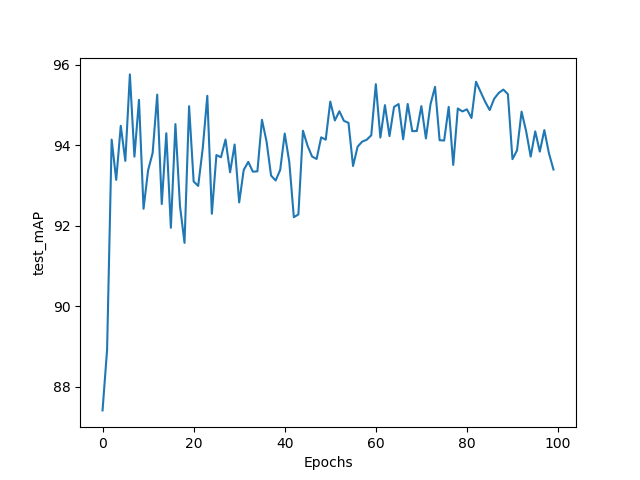

<IPython.core.display.Javascript object>


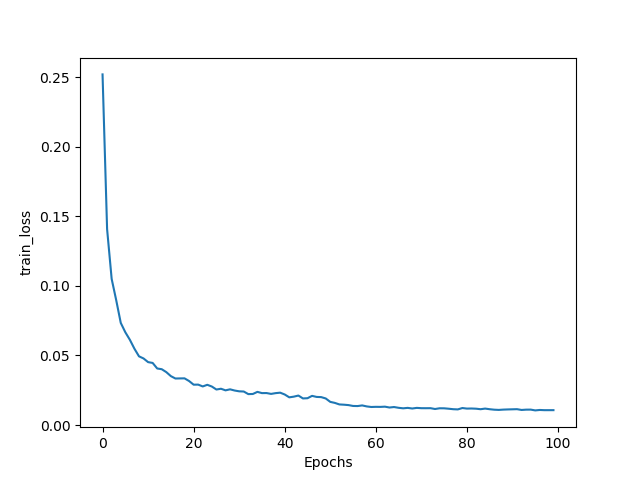

<IPython.core.display.Javascript object>


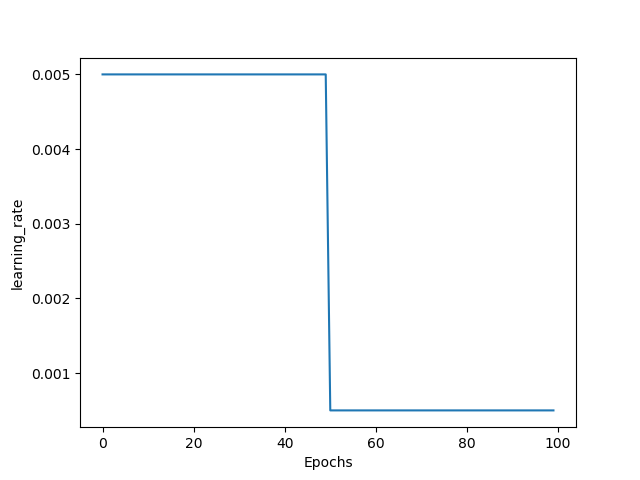

In [3]:
if __name__ == '__main__':
    dataloader_config, trainer_config = patch_configs(epoch_num_to_set=100, batch_size_to_set=2)

    dataset_config = configuration.DatasetConfig(
        root_dir="data",
    )
    
    optimizer_config = configuration.OptimizerConfig(
        learning_rate=5e-3, 
        lr_step_milestones=[50], 
        lr_gamma=0.1, 
        momentum=0.9, 
        weight_decay=1e-5
    )
    
    experiment = Experiment(
        dataset_config=dataset_config, 
        dataloader_config=dataloader_config, 
        optimizer_config=optimizer_config
    )
    
    # Run the experiment / start training
    experiment.run(trainer_config)

<IPython.core.display.Javascript object>


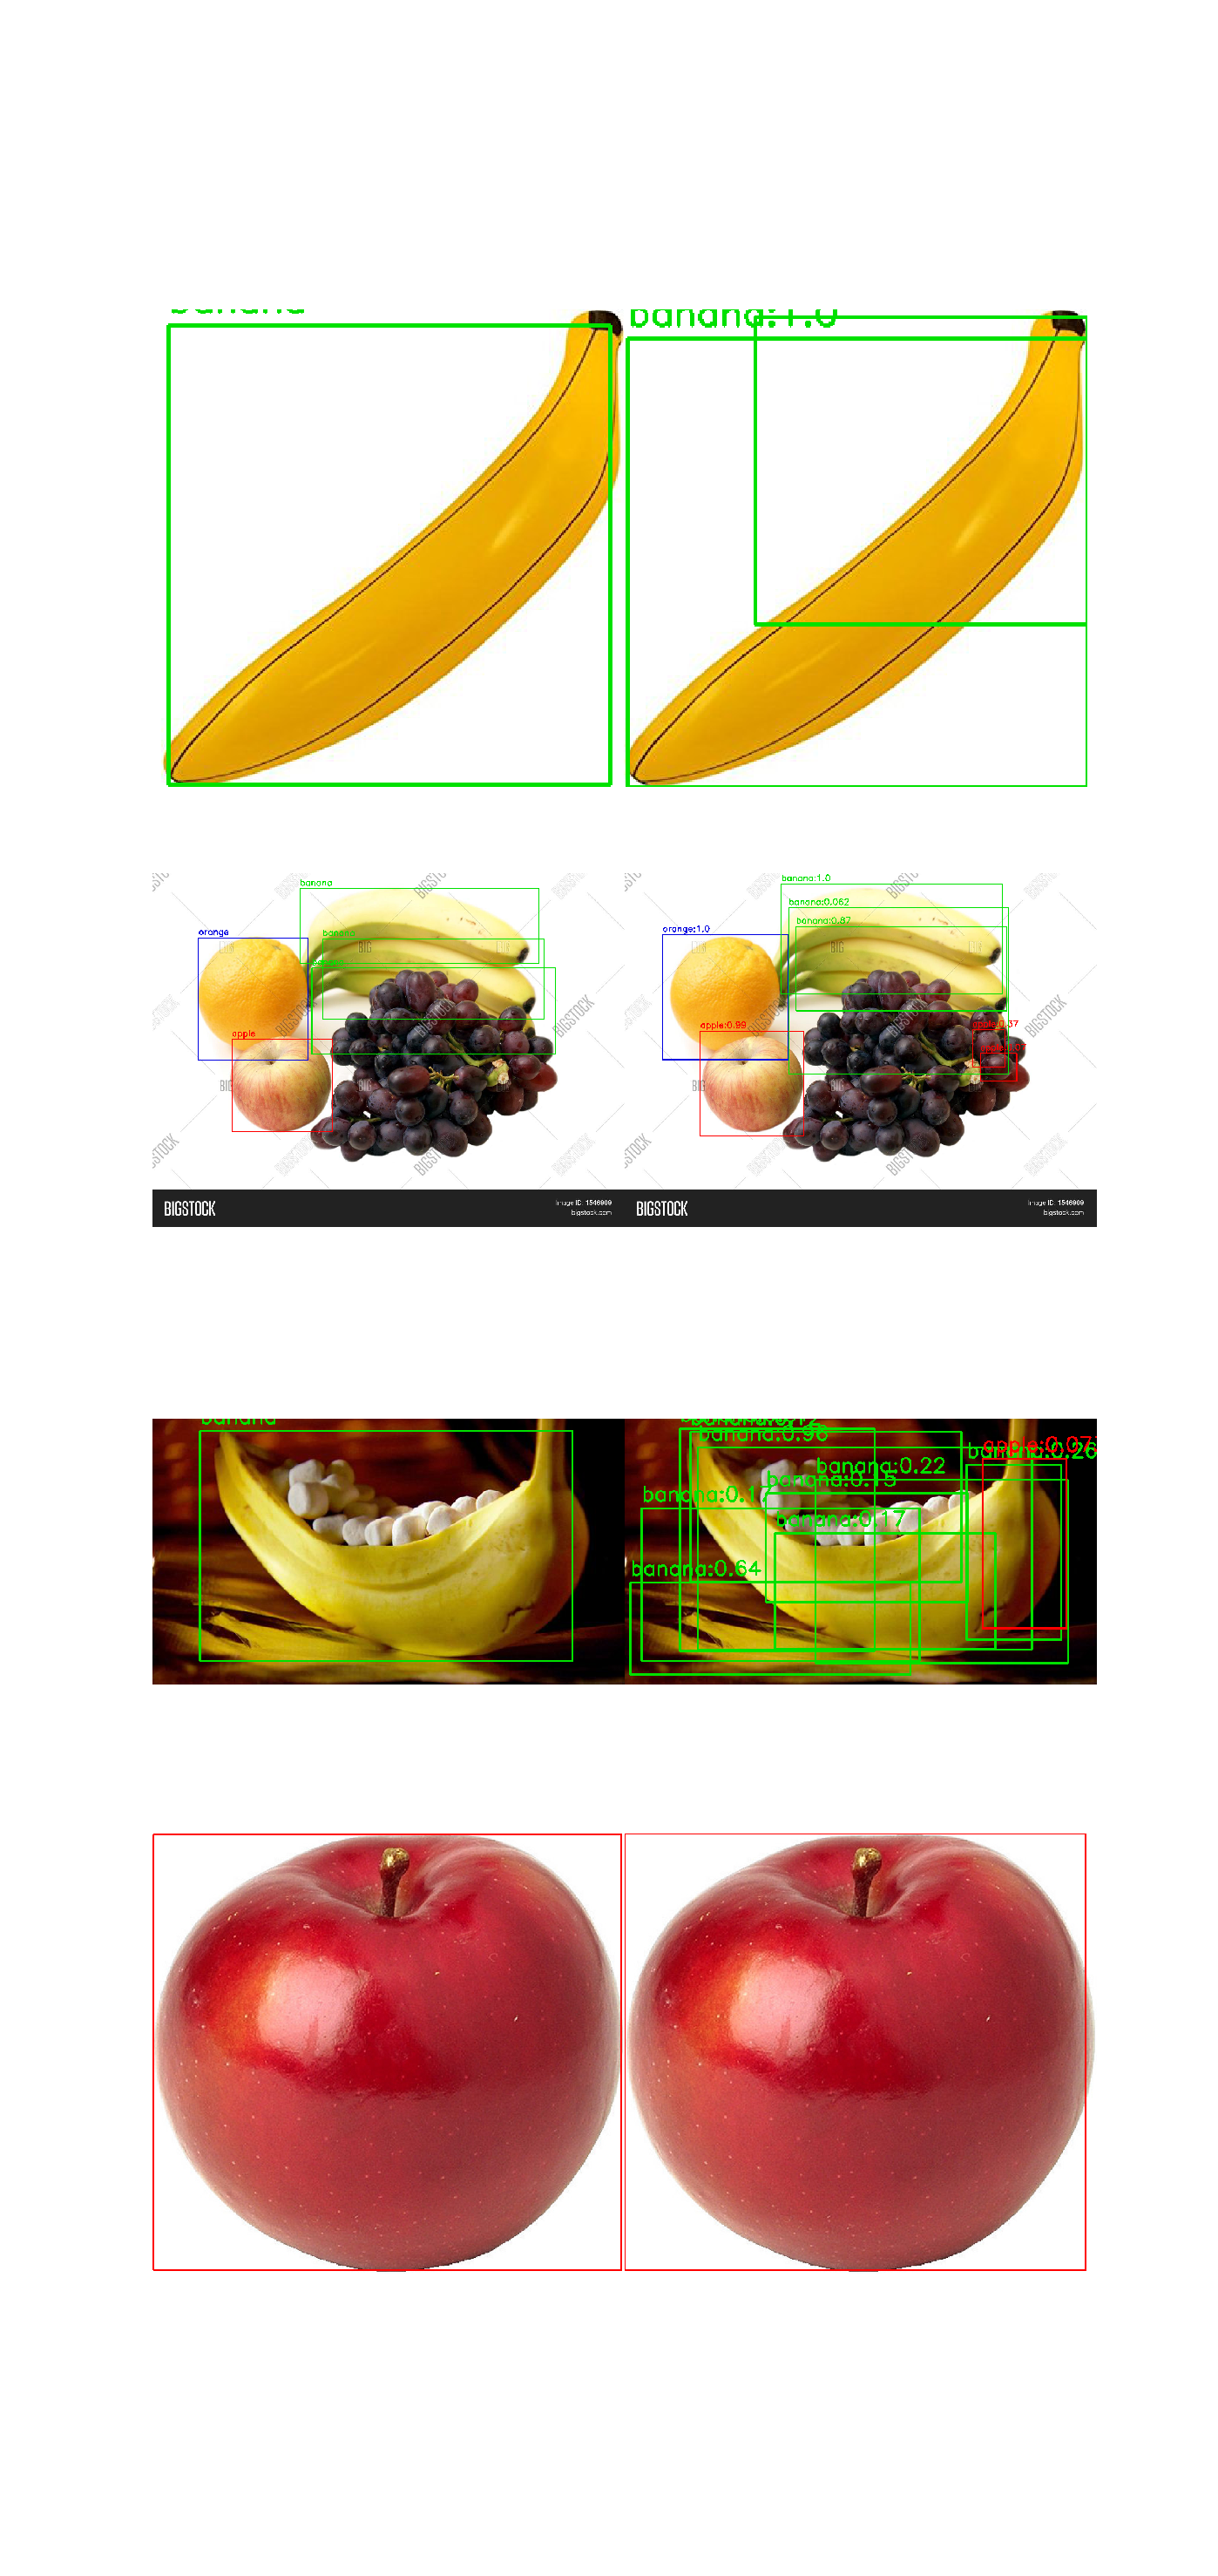

In [4]:
# how good our detector works by visualizing the results on the randomly chosen test images:

if __name__ == '__main__':
    experiment.draw_bboxes(4, 1, trainer_config)

## <font style="color:green">4. Try yourself with a different dataset</font>

Fine-tune the Faster-RCNN model for your own or publicly available datasets. The following are a few links to publicly available datasets:

- [MCIndoor20000](https://github.com/bircatmcri/MCIndoor20000)

- [The Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)

- [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/)

- [KITTI Vision](http://www.cvlibs.net/datasets/kitti/)
